In [1]:
from sklearn import metrics
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

# Data

In [2]:
mef_sce = sc.read_h5ad("/home/ubuntu/data/mef_sce.h5ad")

In [3]:
mef_sce.shape

(315, 22524)

In [4]:
mef_sce.uns

{'X_name': 'logcounts'}

In [5]:
mef_sce.obs.time_point

1_iN1_C01                2
1_iN1_C02                2
1_iN1_C03                2
1_iN1_C04                2
1_iN1_C05                2
                        ..
714_507_1g_22d1_C60     22
714_508_1g_22d1_C72     22
715_506_1gg_22d2_C72    22
715_507_1gg_22d2_C76    22
715_508_1n_22d1_C70     22
Name: time_point, Length: 315, dtype: category
Categories (5, object): ['0', '2', '5', '20', '22']

# Run Psupertime

In [6]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels

psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "hvg"},
                    estimator_params={"penalty": "l1", "max_iter": 75, "early_stopping": False},
                    n_jobs=5,
                    n_batches=1)

anndata = psuper.run("/home/ubuntu/data/mef_sce.h5ad", "time_point")

Input Data: n_genes=22524, n_cells=315
Preprocessing: done. mode='hvg', n_genes=2131, n_cells=315
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.593651.02, n_genes=41
Total elapsed time:  0:01:23.995884


Best idx: 32 Best Score: 0.5904761904761904 Best Lambda: 0.0005223345074266843 Scores std: 0.13355084299396652
1SE idx: 13 1SE Score: 0.5365079365079365 1SE Lambda: 0.046415888336127795


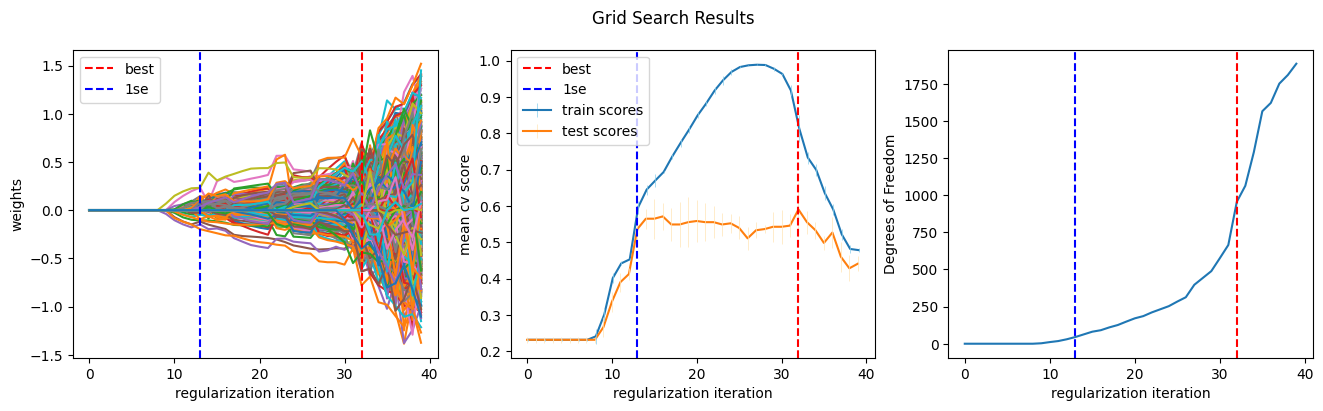

In [7]:
_ = psuper.plot_grid_search()

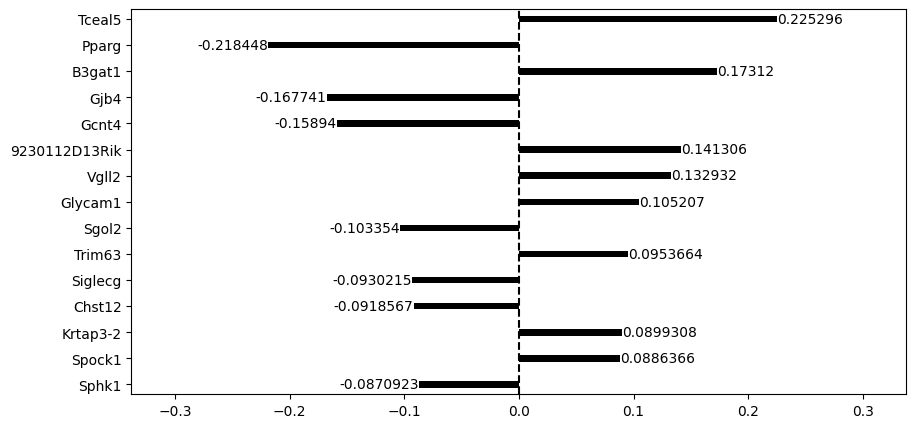

In [8]:
_ = psuper.plot_identified_gene_coefficients(anndata, n_top=15, figsize=(10,5))

Model Degrees of freedom 41
Accuracy: 0.5936507936507937
Balanced accuracy: 0.5004227972264502
Mean absolute delta: 0.6365044662761555


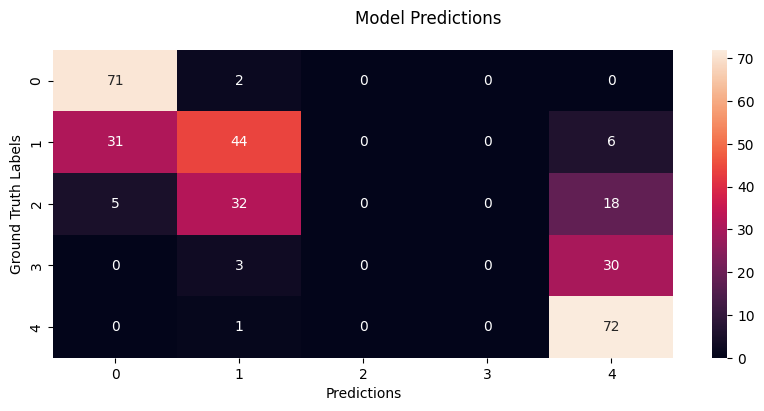

In [9]:
_ = psuper.plot_model_perf(train=(anndata.X, anndata.obs.ordinal_label))

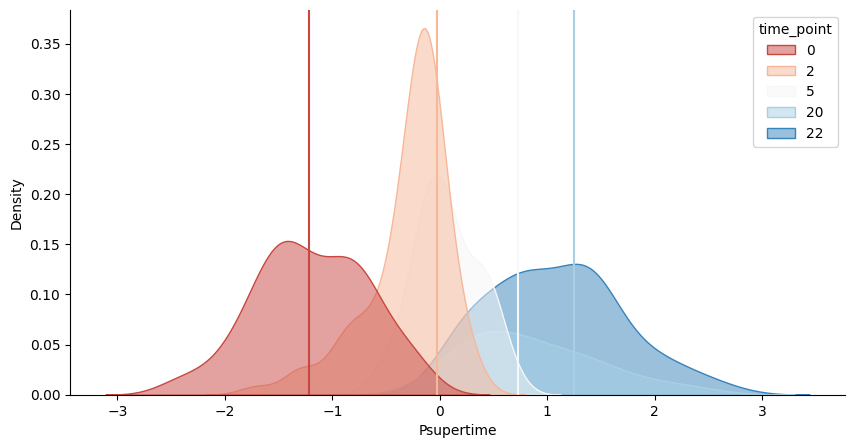

In [10]:
fig = psuper.plot_labels_over_psupertime(anndata, "time_point")

In [11]:
from sklearn import metrics
print("Abs Error:", metrics.mean_absolute_error(anndata.obs.ordinal_label, anndata.obs.predicted_label))
print("Balanced Acc:", metrics.balanced_accuracy_score(anndata.obs.ordinal_label, anndata.obs.predicted_label))

n_genes_start = 26178
dof =  np.count_nonzero(psuper.model.coef_)
print("DoF (sparsity): %s (%s)" % (dof, 1 - (dof / n_genes_start) ))

Abs Error: 0.5333333333333333
Balanced Acc: 0.5004227972264502
DoF (sparsity): 41 (0.9984337993735197)


## Repeat on Different Seeds

In [12]:
seeds = [27, 631, 54, 42, 9]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [14]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "hvg"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run("/home/ubuntu/data/mef_sce.h5ad", "time_point")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 27
Input Data: n_genes=22524, n_cells=315
Preprocessing: done. mode='hvg', n_genes=2131, n_cells=315
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.600000.02, n_genes=39
Total elapsed time:  0:01:25.639111
Input Data: n_genes=2131, n_cells=315
Refit on all data: done. accuracy=0.920635.02, n_genes=744
Iter 1, seed 631
Input Data: n_genes=22524, n_cells=315
Preprocessing: done. mode='hvg', n_genes=2131, n_cells=315
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.606349.02, n_genes=39
Total elapsed time:  0:01:22.786291
Input Data: n_genes=2131, n_cells=315
Refit on all data: done. accuracy=0.987302.02, n_genes=653
Iter 2, seed 54
Input Data: n_genes=22524, n_cells=315
Preprocessing: done. mode='hvg', n_genes=2131, n_cells=315
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.990476.02, n_genes=597
Total elapsed time:  0:01:22.835963
Input 

In [15]:
import numpy as np

num_input_genes = 26178
hvg = 3757

print("1se model")
print("accuracy: %s (%s)" % (np.mean(acc_1se), np.std(acc_1se)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_1se), np.std(bacc_1se)))
print("dof: %s (%s)" % (np.mean(dof_1se) , np.std(dof_1se)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_1se) / num_input_genes), np.std(dof_1se) / num_input_genes))
print("Sparsity (hvg): %s (%s)" % (1- (np.mean(dof_1se) / hvg), np.std(dof_1se) / hvg))
print()

print("best model")
print("accuracy: %s (%s)" % (np.mean(acc_best), np.std(acc_best)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_best), np.std(bacc_best)))
print("dof: %s (%s)" % (np.mean(dof_best) , np.std(dof_best)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_best) / num_input_genes), np.std(dof_best) / num_input_genes))
print("Sparsity (hvg): %s (%s)" % (1 - (np.mean(dof_best) / hvg), np.std(dof_best) / hvg))

1se model
accuracy: 0.681904761904762 (0.15431837135600307)
balanced accuracy: 0.602478975447012 (0.18968550534371934)
dof: 150.8 (223.10212907993505)
Sparsity (all genes): 0.994239437695775 (0.008522504739855415)
Sparsity (hvg): 0.9598615916955018 (0.05938305272289993)

best model
accuracy: 0.9320634920634919 (0.03515649066643082)
balanced accuracy: 0.8756184062850728 (0.06265711142191112)
dof: 746.8 (66.58047761919406)
Sparsity (all genes): 0.9714722285888915 (0.002543375262403318)
Sparsity (hvg): 0.801224381155177 (0.01772171349991857)


## Repeat on Different Seeds (all Genes)

In [16]:
seeds = [27, 631, 54, 42, 9]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [17]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "all"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run("/home/ubuntu/data/mef_sce.h5ad", "time_point")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 27
Input Data: n_genes=22524, n_cells=315
Preprocessing: done. mode='all', n_genes=14036, n_cells=315
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.698413.02, n_genes=46
Total elapsed time:  0:20:51.822849
Input Data: n_genes=14036, n_cells=315
Refit on all data: done. accuracy=0.863492.02, n_genes=114
Iter 1, seed 631
Input Data: n_genes=22524, n_cells=315
Preprocessing: done. mode='all', n_genes=14036, n_cells=315
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.720635.02, n_genes=50
Total elapsed time:  0:20:06.540469
Input Data: n_genes=14036, n_cells=315
Refit on all data: done. accuracy=0.873016.02, n_genes=120
Iter 2, seed 54
Input Data: n_genes=22524, n_cells=315
Preprocessing: done. mode='all', n_genes=14036, n_cells=315
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.733333.02, n_genes=49
Total elapsed time:  0:20:17.110093
In

In [35]:
import numpy as np

def latex_tabular_fmt(acc, dof, n):
    acc_mean = np.round(np.mean(acc) * 100, 2)
    sparsity_mean = np.round((1 - (np.mean(dof) / n)) * 100, 2)
    acc_std = np.round(np.std(acc) * 100, 1)
    sparsity_std = np.round((np.std(dof) / n) * 100, 1)

    latex_template = "$%s \\pm %s$  &  $%s \\pm %s$"
    return latex_template % (acc_mean, acc_std, sparsity_mean, sparsity_std)

num_input_genes = 14036

print("1se model")
print("accuracy: %s (%s)" % (np.mean(acc_1se), np.std(acc_1se)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_1se), np.std(bacc_1se)))
print("dof: %s (%s)" % (np.mean(dof_1se) , np.std(dof_1se)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_1se) / num_input_genes), np.std(dof_1se) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_1se, dof_1se, num_input_genes))
print()

print("best model")
print("accuracy: %s (%s)" % (np.mean(acc_best), np.std(acc_best)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_best), np.std(bacc_best)))
print("dof: %s (%s)" % (np.mean(dof_best) , np.std(dof_best)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_best) / num_input_genes), np.std(dof_best) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_best, dof_best, num_input_genes))


1se model
accuracy: 0.7022222222222222 (0.03246177277755989)
balanced accuracy: 0.6111245791245791 (0.03243300228704073)
dof: 47.0 (3.286335345030997)
Sparsity (all genes): 0.9982045992818397 (0.00012553806039540823)
LATEX: accuracy & sparsity \\
$70.22 \pm 3.2$  &  $99.82 \pm 0.0$

best model
accuracy: 0.8800000000000001 (0.012602814756367743)
balanced accuracy: 0.7889203142536475 (0.014151754365438267)
dof: 120.0 (4.9396356140913875)
Sparsity (all genes): 0.9954159981663993 (0.00018869415593595338)
LATEX: accuracy & sparsity \\
$88.0 \pm 1.3$  &  $99.54 \pm 0.0$
